# Multimodal Sentiment Analysis - Data Preprocessing

This notebook handles the initial data loading, timestamp synchronization, and feature extraction for multimodal sentiment analysis using EEG, GSR, facial action units, and self-report data.

**Objective**: Classify sentiment into positive (1), negative (2), and neutral (0) categories using multimodal physiological and behavioral signals.

## 1. Project Setup and Library Imports

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette("husl")

print("Libraries loaded successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries loaded successfully!
Pandas version: 2.3.2
NumPy version: 1.26.4


## Data Visualization Configuration

Setting up enhanced plotting parameters for comprehensive data visualization.

In [27]:
# Enhanced plotting configuration
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Custom color palette for multimodal data
modality_colors = {
    'EEG': '#FF6B6B',      # Red
    'GSR': '#4ECDC4',      # Teal  
    'AU': '#45B7D1',       # Blue
    'SR': '#96CEB4',       # Green
    'Combined': '#FECA57'   # Yellow
}

sentiment_colors = {
    'Negative': '#FF6B6B',  # Red
    'Neutral': '#95A5A6',   # Gray
    'Positive': '#2ECC71'   # Green
}

print("📊 Visualization configuration set!")
print("Color scheme:")
for modality, color in modality_colors.items():
    print(f"  {modality}: {color}")
print("Sentiment colors:")
for sentiment, color in sentiment_colors.items():
    print(f"  {sentiment}: {color}")

📊 Visualization configuration set!
Color scheme:
  EEG: #FF6B6B
  GSR: #4ECDC4
  AU: #45B7D1
  SR: #96CEB4
  Combined: #FECA57
Sentiment colors:
  Negative: #FF6B6B
  Neutral: #95A5A6
  Positive: #2ECC71


## 2. Data Loading and Initial Exploration

In [11]:
# Define data paths
data_dir = '../data/'
required_files = ['PSY.csv', 'EEG.csv', 'GSR.csv', 'TIVA.csv', 'NSTLX.csv']

# Function to load and examine datasets
def load_and_explore_data():
    datasets = {}
    
    for file in required_files:
        file_path = os.path.join(data_dir, file)
        
        if os.path.exists(file_path):
            try:
                df = pd.read_csv(file_path)
                datasets[file.replace('.csv', '')] = df
                
                print(f"\n{file} loaded successfully:")
                print(f"  Shape: {df.shape}")
                print(f"  Columns: {list(df.columns)}")
                print(f"  Missing values: {df.isnull().sum().sum()}")
                print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
                
                # Show first few rows
                print(f"  Sample data:")
                print(df.head(2))
                
            except Exception as e:
                print(f"Error loading {file}: {str(e)}")
        else:
            print(f"\n{file} not found. Please ensure all data files are in the data/ directory.")
    
    return datasets

# Load all datasets
datasets = load_and_explore_data()


PSY.csv loaded successfully:
  Shape: (1448, 7)
  Columns: ['ParticipantID', 'Category', 'QuestionNumber', 'Difficulty', 'ResponseTime', 'routineStart', 'routineEnd']
  Missing values: 38
  Memory usage: 0.21 MB
  Sample data:
   ParticipantID  Category QuestionNumber Difficulty  ResponseTime  \
0              1         1           spl1       Easy     10.369816   
1              1         1           spl2       Easy      7.913992   

   routineStart    routineEnd  
0  1.680003e+09  1.680003e+09  
1  1.680003e+09  1.680003e+09  

EEG.csv loaded successfully:
  Shape: (11475260, 21)
  Columns: ['ParticipantID', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10']
  Missing values: 239940
  Memory usage: 1838.54 MB
  Sample data:
   ParticipantID  Delta_TP9  Delta_AF7  Delta_AF8  Del

## 3. Timestamp Synchronization and Trial Extraction

In [12]:
def synchronize_timestamps(datasets):
    """
    Synchronize timestamps across modalities and extract trial windows
    """
    synchronized_data = {}
    
    # Check if datasets were loaded successfully
    if not datasets:
        print("No datasets loaded. Please check data files.")
        return synchronized_data
    
    # Extract trial information from PSY data (contains routineStart/routineEnd)
    if 'PSY' in datasets:
        psy_data = datasets['PSY'].copy()
        print(f"PSY data columns: {list(psy_data.columns)}")
        
        # Look for common timestamp and trial columns
        time_cols = [col for col in psy_data.columns if 'time' in col.lower() or 'timestamp' in col.lower()]
        trial_cols = [col for col in psy_data.columns if 'trial' in col.lower() or 'routine' in col.lower()]
        
        print(f"Found time columns: {time_cols}")
        print(f"Found trial columns: {trial_cols}")
        
        # Extract unique trials/participants
        participant_cols = [col for col in psy_data.columns if 'participant' in col.lower() or 'subject' in col.lower()]
        
        if participant_cols:
            print(f"Found participant columns: {participant_cols}")
            unique_participants = psy_data[participant_cols[0]].unique()
            print(f"Number of unique participants: {len(unique_participants)}")
        
        synchronized_data['PSY'] = psy_data
    
    # Process each modality
    for modality, data in datasets.items():
        if modality != 'PSY':
            # Standardize timestamp column names
            time_cols = [col for col in data.columns if 'time' in col.lower()]
            if time_cols:
                # Rename first time column to 'timestamp' for consistency
                data_copy = data.copy()
                data_copy = data_copy.rename(columns={time_cols[0]: 'timestamp'})
                synchronized_data[modality] = data_copy
                print(f"{modality} data synchronized with {len(data_copy)} records")
            else:
                print(f"Warning: No timestamp column found in {modality} data")
                synchronized_data[modality] = data
    
    return synchronized_data

# Synchronize all datasets
sync_data = synchronize_timestamps(datasets)
print(f"\nSynchronized {len(sync_data)} modalities successfully")

PSY data columns: ['ParticipantID', 'Category', 'QuestionNumber', 'Difficulty', 'ResponseTime', 'routineStart', 'routineEnd']
Found time columns: ['ResponseTime']
Found trial columns: ['routineStart', 'routineEnd']
Found participant columns: ['ParticipantID']
Number of unique participants: 38
GSR data synchronized with 5349031 records
NSTLX data synchronized with 112 records

Synchronized 5 modalities successfully


## 4. EEG Feature Extraction

In [13]:
def extract_eeg_features(eeg_data):
    """
    Extract EEG features including frequency bands and engagement metrics
    """
    if eeg_data is None or eeg_data.empty:
        print("No EEG data available for feature extraction")
        return pd.DataFrame()
    
    print(f"Extracting EEG features from {len(eeg_data)} records")
    print(f"EEG columns: {list(eeg_data.columns)}")
    
    # Identify frequency band columns
    frequency_bands = {
        'delta': [col for col in eeg_data.columns if 'delta' in col.lower()],
        'theta': [col for col in eeg_data.columns if 'theta' in col.lower()],
        'alpha': [col for col in eeg_data.columns if 'alpha' in col.lower()],
        'beta': [col for col in eeg_data.columns if 'beta' in col.lower()],
        'gamma': [col for col in eeg_data.columns if 'gamma' in col.lower()]
    }
    
    engagement_cols = [col for col in eeg_data.columns if 'engagement' in col.lower() or 'attention' in col.lower()]
    
    print(f"Found frequency bands: {frequency_bands}")
    print(f"Found engagement columns: {engagement_cols}")
    
    # Extract statistical features for each frequency band
    eeg_features = pd.DataFrame()
    
    # Group by participant or trial if available
    participant_col = None
    for col in eeg_data.columns:
        if 'participant' in col.lower() or 'subject' in col.lower():
            participant_col = col
            break
    
    if participant_col:
        grouped = eeg_data.groupby(participant_col)
        print(f"Processing EEG data by {participant_col}")
    else:
        # If no participant column, treat as single group
        grouped = [(0, eeg_data)]
        print("Processing EEG data as single group")
    
    feature_list = []
    
    for group_id, group_data in grouped:
        features = {'participant_id': group_id}
        
        # Extract frequency band features
        for band, cols in frequency_bands.items():
            if cols:
                band_data = group_data[cols]
                features[f'{band}_mean'] = band_data.mean().mean()
                features[f'{band}_std'] = band_data.std().mean()
                features[f'{band}_max'] = band_data.max().max()
                features[f'{band}_min'] = band_data.min().min()
        
        # Extract engagement features
        for col in engagement_cols:
            if col in group_data.columns:
                features[f'{col}_mean'] = group_data[col].mean()
                features[f'{col}_std'] = group_data[col].std()
        
        # Calculate frontal asymmetry if frontal channels available
        frontal_left = [col for col in group_data.columns if any(x in col.lower() for x in ['f3', 'f7', 'fp1'])]
        frontal_right = [col for col in group_data.columns if any(x in col.lower() for x in ['f4', 'f8', 'fp2'])]
        
        if frontal_left and frontal_right:
            left_alpha = group_data[frontal_left].mean(axis=1).mean()
            right_alpha = group_data[frontal_right].mean(axis=1).mean()
            features['frontal_asymmetry'] = np.log(right_alpha) - np.log(left_alpha)
        
        feature_list.append(features)
    
    eeg_features = pd.DataFrame(feature_list)
    print(f"Extracted EEG features shape: {eeg_features.shape}")
    
    return eeg_features

# Extract EEG features
if 'EEG' in sync_data:
    eeg_features = extract_eeg_features(sync_data['EEG'])
    print(f"\nEEG feature extraction completed")
    if not eeg_features.empty:
        print(f"Feature columns: {list(eeg_features.columns)}")
else:
    print("EEG data not available")

Extracting EEG features from 11475260 records
EEG columns: ['ParticipantID', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10']
Found frequency bands: {'delta': ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10'], 'theta': ['Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10'], 'alpha': ['Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10'], 'beta': ['Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10'], 'gamma': ['Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10']}
Found engagement columns: []
Processing EEG data by ParticipantID
Extracted EEG features shape: (38, 22)

EEG feature extraction completed
Feature columns: ['participant_id', 'delta_mean', 'delta_std', 'delta_max', 'delta_min', 'theta_mean', 'theta_std', 'theta_max', 'theta_min', 'alpha_mean', 'alpha_std', 'alpha_max', 'a

## 5. GSR Feature Extraction

In [14]:
def extract_gsr_features(gsr_data):
    """
    Extract GSR features including conductance level, SCR peaks, and recovery metrics
    """
    if gsr_data is None or gsr_data.empty:
        print("No GSR data available for feature extraction")
        return pd.DataFrame()
    
    print(f"Extracting GSR features from {len(gsr_data)} records")
    print(f"GSR columns: {list(gsr_data.columns)}")
    
    # Identify GSR signal columns
    gsr_cols = [col for col in gsr_data.columns if any(x in col.lower() for x in ['gsr', 'conductance', 'eda', 'scr'])]
    
    if not gsr_cols:
        # If no specific GSR columns found, use numeric columns (excluding timestamps)
        numeric_cols = gsr_data.select_dtypes(include=[np.number]).columns
        time_cols = [col for col in numeric_cols if 'time' in col.lower()]
        gsr_cols = [col for col in numeric_cols if col not in time_cols]
    
    print(f"Using GSR columns: {gsr_cols}")
    
    # Group by participant if available
    participant_col = None
    for col in gsr_data.columns:
        if 'participant' in col.lower() or 'subject' in col.lower():
            participant_col = col
            break
    
    if participant_col:
        grouped = gsr_data.groupby(participant_col)
        print(f"Processing GSR data by {participant_col}")
    else:
        grouped = [(0, gsr_data)]
        print("Processing GSR data as single group")
    
    feature_list = []
    
    for group_id, group_data in grouped:
        features = {'participant_id': group_id}
        
        for col in gsr_cols:
            if col in group_data.columns:
                signal = group_data[col].dropna()
                
                if len(signal) > 0:
                    # Basic statistical features
                    features[f'{col}_mean'] = signal.mean()
                    features[f'{col}_std'] = signal.std()
                    features[f'{col}_max'] = signal.max()
                    features[f'{col}_min'] = signal.min()
                    features[f'{col}_range'] = signal.max() - signal.min()
                    
                    # Detect SCR peaks (simple peak detection)
                    signal_smooth = signal.rolling(window=3, center=True).mean().fillna(signal)
                    signal_diff = signal_smooth.diff()
                    
                    # Count peaks (positive to negative transitions)
                    peaks = 0
                    for i in range(1, len(signal_diff)-1):
                        if signal_diff.iloc[i-1] > 0 and signal_diff.iloc[i+1] < 0:
                            peaks += 1
                    
                    features[f'{col}_peaks'] = peaks
                    features[f'{col}_peak_rate'] = peaks / len(signal) * 1000 if len(signal) > 0 else 0
                    
                    # Recovery slope (approximate)
                    if len(signal) > 10:
                        recovery_slope = np.polyfit(range(len(signal)), signal, 1)[0]
                        features[f'{col}_recovery_slope'] = recovery_slope
                    else:
                        features[f'{col}_recovery_slope'] = 0
        
        feature_list.append(features)
    
    gsr_features = pd.DataFrame(feature_list)
    print(f"Extracted GSR features shape: {gsr_features.shape}")
    
    return gsr_features

# Extract GSR features
if 'GSR' in sync_data:
    gsr_features = extract_gsr_features(sync_data['GSR'])
    print(f"\nGSR feature extraction completed")
    if not gsr_features.empty:
        print(f"Feature columns: {list(gsr_features.columns)}")
else:
    print("GSR data not available")

Extracting GSR features from 5349031 records
GSR columns: ['ParticipantID', 'GSR Resistance CAL', 'GSR Conductance CAL', 'GSR RAW', 'timestamp', 'Timestamp']
Using GSR columns: ['GSR Resistance CAL', 'GSR Conductance CAL', 'GSR RAW']
Processing GSR data by ParticipantID
Extracted GSR features shape: (38, 25)

GSR feature extraction completed
Feature columns: ['participant_id', 'GSR Resistance CAL_mean', 'GSR Resistance CAL_std', 'GSR Resistance CAL_max', 'GSR Resistance CAL_min', 'GSR Resistance CAL_range', 'GSR Resistance CAL_peaks', 'GSR Resistance CAL_peak_rate', 'GSR Resistance CAL_recovery_slope', 'GSR Conductance CAL_mean', 'GSR Conductance CAL_std', 'GSR Conductance CAL_max', 'GSR Conductance CAL_min', 'GSR Conductance CAL_range', 'GSR Conductance CAL_peaks', 'GSR Conductance CAL_peak_rate', 'GSR Conductance CAL_recovery_slope', 'GSR RAW_mean', 'GSR RAW_std', 'GSR RAW_max', 'GSR RAW_min', 'GSR RAW_range', 'GSR RAW_peaks', 'GSR RAW_peak_rate', 'GSR RAW_recovery_slope']


## 6. Facial Action Units Processing

In [15]:
def extract_au_features(tiva_data):
    """
    Extract Facial Action Unit features from TIVA data
    """
    if tiva_data is None or tiva_data.empty:
        print("No TIVA data available for feature extraction")
        return pd.DataFrame()
    
    print(f"Extracting AU features from {len(tiva_data)} records")
    print(f"TIVA columns: {list(tiva_data.columns)}")
    
    # Define emotion-relevant Action Units
    emotion_aus = {
        'happiness': ['AU06', 'AU12'],  # Cheek raiser, Lip corner puller
        'sadness': ['AU01', 'AU04', 'AU15'],  # Inner brow raiser, Brow lowerer, Lip corner depressor
        'anger': ['AU04', 'AU05', 'AU07', 'AU23'],  # Brow lowerer, Upper lid raiser, Lid tightener, Lip tightener
        'surprise': ['AU01', 'AU02', 'AU05', 'AU26'],  # Inner brow raiser, Outer brow raiser, Upper lid raiser, Jaw drop
        'disgust': ['AU09', 'AU10'],  # Nose wrinkler, Upper lip raiser
        'fear': ['AU01', 'AU02', 'AU04', 'AU05', 'AU07', 'AU20', 'AU26']  # Various combinations
    }
    
    # Find AU columns in the data
    au_cols = [col for col in tiva_data.columns if 'AU' in col.upper() or 'au' in col.lower()]
    
    if not au_cols:
        # Look for numbered columns that might be AUs
        au_cols = [col for col in tiva_data.columns if any(str(i) in col for i in range(1, 46))]
    
    print(f"Found AU columns: {au_cols}")
    
    # Group by participant if available
    participant_col = None
    for col in tiva_data.columns:
        if 'participant' in col.lower() or 'subject' in col.lower():
            participant_col = col
            break
    
    if participant_col:
        grouped = tiva_data.groupby(participant_col)
        print(f"Processing AU data by {participant_col}")
    else:
        grouped = [(0, tiva_data)]
        print("Processing AU data as single group")
    
    feature_list = []
    
    for group_id, group_data in grouped:
        features = {'participant_id': group_id}
        
        # Extract features for each AU
        for col in au_cols:
            if col in group_data.columns:
                au_signal = group_data[col].dropna()
                
                if len(au_signal) > 0:
                    # Basic statistical features
                    features[f'{col}_mean'] = au_signal.mean()
                    features[f'{col}_std'] = au_signal.std()
                    features[f'{col}_max'] = au_signal.max()
                    features[f'{col}_activation_rate'] = (au_signal > 0.5).mean()  # Assuming 0-5 scale
        
        # Calculate emotion-specific AU combinations
        for emotion, aus in emotion_aus.items():
            emotion_score = 0
            au_count = 0
            
            for au in aus:
                # Find matching columns for this AU
                matching_cols = [col for col in au_cols if au.lower() in col.lower() or au.upper() in col]
                
                for col in matching_cols:
                    if col in group_data.columns:
                        emotion_score += group_data[col].mean()
                        au_count += 1
            
            if au_count > 0:
                features[f'{emotion}_composite'] = emotion_score / au_count
            else:
                features[f'{emotion}_composite'] = 0
        
        # Calculate valence and arousal approximations
        # Valence: positive emotions (happiness) vs negative emotions (sadness, anger, disgust)
        positive_aus = emotion_aus['happiness']
        negative_aus = emotion_aus['sadness'] + emotion_aus['anger'] + emotion_aus['disgust']
        
        positive_score = 0
        negative_score = 0
        
        for au in positive_aus:
            matching_cols = [col for col in au_cols if au.lower() in col.lower() or au.upper() in col]
            for col in matching_cols:
                if col in group_data.columns:
                    positive_score += group_data[col].mean()
        
        for au in negative_aus:
            matching_cols = [col for col in au_cols if au.lower() in col.lower() or au.upper() in col]
            for col in matching_cols:
                if col in group_data.columns:
                    negative_score += group_data[col].mean()
        
        features['valence_au'] = positive_score - negative_score
        
        # Arousal: high activation emotions (anger, fear, surprise) vs low activation (sadness)
        high_arousal_aus = emotion_aus['anger'] + emotion_aus['fear'] + emotion_aus['surprise']
        low_arousal_aus = emotion_aus['sadness']
        
        high_arousal_score = 0
        low_arousal_score = 0
        
        for au in high_arousal_aus:
            matching_cols = [col for col in au_cols if au.lower() in col.lower() or au.upper() in col]
            for col in matching_cols:
                if col in group_data.columns:
                    high_arousal_score += group_data[col].mean()
        
        for au in low_arousal_aus:
            matching_cols = [col for col in au_cols if au.lower() in col.lower() or au.upper() in col]
            for col in matching_cols:
                if col in group_data.columns:
                    low_arousal_score += group_data[col].mean()
        
        features['arousal_au'] = high_arousal_score - low_arousal_score
        
        feature_list.append(features)
    
    au_features = pd.DataFrame(feature_list)
    print(f"Extracted AU features shape: {au_features.shape}")
    
    return au_features

# Extract AU features
if 'TIVA' in sync_data:
    au_features = extract_au_features(sync_data['TIVA'])
    print(f"\nAU feature extraction completed")
    if not au_features.empty:
        print(f"Feature columns: {list(au_features.columns)}")
else:
    print("TIVA data not available")

Extracting AU features from 425096 records
TIVA columns: ['ParticipantID', 'Joy', 'Sadness', 'Anger', 'Fear', 'Surprise', 'Disgust']
Found AU columns: []
Processing AU data by ParticipantID
Extracted AU features shape: (38, 9)

AU feature extraction completed
Feature columns: ['participant_id', 'happiness_composite', 'sadness_composite', 'anger_composite', 'surprise_composite', 'disgust_composite', 'fear_composite', 'valence_au', 'arousal_au']


## 7. Self-Report Data Integration

In [16]:
def extract_selfreport_features(psy_data):
    """
    Extract self-report features and sentiment labels from PSY data
    """
    if psy_data is None or psy_data.empty:
        print("No PSY/self-report data available")
        return pd.DataFrame(), pd.Series()
    
    print(f"Processing self-report data: {psy_data.shape}")
    print(f"PSY columns: {list(psy_data.columns)}")
    
    # Look for sentiment/emotion related columns
    sentiment_cols = [col for col in psy_data.columns if any(x in col.lower() for x in 
                     ['sentiment', 'emotion', 'valence', 'arousal', 'positive', 'negative', 'neutral'])]
    
    # Look for rating/scale columns
    rating_cols = [col for col in psy_data.columns if any(x in col.lower() for x in 
                  ['rating', 'scale', 'score', 'level'])]
    
    print(f"Found sentiment columns: {sentiment_cols}")
    print(f"Found rating columns: {rating_cols}")
    
    # Extract target labels (sentiment)
    target_col = None
    target_labels = pd.Series()
    
    # Try to find the main sentiment target column
    for col in psy_data.columns:
        if 'sentiment' in col.lower() or 'label' in col.lower():
            target_col = col
            break
    
    if target_col:
        target_labels = psy_data[target_col].copy()
        print(f"Using {target_col} as target variable")
        print(f"Target distribution: \n{target_labels.value_counts()}")
    else:
        # Try to create sentiment labels from valence if available
        valence_cols = [col for col in psy_data.columns if 'valence' in col.lower()]
        if valence_cols:
            valence = psy_data[valence_cols[0]]
            # Convert valence to sentiment (simple threshold-based)
            target_labels = pd.cut(valence, bins=[-np.inf, -0.5, 0.5, np.inf], 
                                 labels=[2, 0, 1])  # Negative=2, Neutral=0, Positive=1
            print(f"Created sentiment labels from valence: \n{target_labels.value_counts()}")
    
    # Extract self-report features
    participant_col = None
    for col in psy_data.columns:
        if 'participant' in col.lower() or 'subject' in col.lower():
            participant_col = col
            break
    
    feature_list = []
    
    if participant_col:
        grouped = psy_data.groupby(participant_col)
        print(f"Processing self-report data by {participant_col}")
        
        for group_id, group_data in grouped:
            features = {'participant_id': group_id}
            
            # Extract numerical features
            numeric_cols = group_data.select_dtypes(include=[np.number]).columns
            exclude_cols = ['participant', 'subject', 'trial', 'time']
            
            for col in numeric_cols:
                if not any(exc in col.lower() for exc in exclude_cols):
                    if not group_data[col].isna().all():
                        features[f'sr_{col}_mean'] = group_data[col].mean()
                        features[f'sr_{col}_std'] = group_data[col].std()
                        if col in sentiment_cols or col in rating_cols:
                            features[f'sr_{col}_max'] = group_data[col].max()
                            features[f'sr_{col}_min'] = group_data[col].min()
            
            feature_list.append(features)
    
    else:
        # Single participant case
        features = {'participant_id': 0}
        numeric_cols = psy_data.select_dtypes(include=[np.number]).columns
        
        for col in numeric_cols:
            if not psy_data[col].isna().all():
                features[f'sr_{col}_mean'] = psy_data[col].mean()
                features[f'sr_{col}_std'] = psy_data[col].std()
        
        feature_list.append(features)
    
    selfreport_features = pd.DataFrame(feature_list)
    print(f"Extracted self-report features shape: {selfreport_features.shape}")
    
    return selfreport_features, target_labels

# Extract self-report features and labels
if 'PSY' in sync_data:
    selfreport_features, sentiment_labels = extract_selfreport_features(sync_data['PSY'])
    print(f"\nSelf-report feature extraction completed")
    if not selfreport_features.empty:
        print(f"Feature columns: {list(selfreport_features.columns)}")
    if not sentiment_labels.empty:
        print(f"Sentiment labels available: {len(sentiment_labels)} samples")
else:
    print("PSY/self-report data not available")
    selfreport_features = pd.DataFrame()
    sentiment_labels = pd.Series()

Processing self-report data: (1448, 7)
PSY columns: ['ParticipantID', 'Category', 'QuestionNumber', 'Difficulty', 'ResponseTime', 'routineStart', 'routineEnd']
Found sentiment columns: []
Found rating columns: []
Processing self-report data by ParticipantID
Extracted self-report features shape: (38, 7)

Self-report feature extraction completed
Feature columns: ['participant_id', 'sr_Category_mean', 'sr_Category_std', 'sr_routineStart_mean', 'sr_routineStart_std', 'sr_routineEnd_mean', 'sr_routineEnd_std']


## 8. Multimodal Feature Integration

In [19]:
def integrate_multimodal_features():
    """
    Combine features from all modalities into a unified dataset
    """
    print("Integrating multimodal features...")
    
    # Collect all available feature dataframes
    feature_dfs = []
    modality_names = []
    
    # Check global variables directly
    if 'eeg_features' in globals() and not eeg_features.empty:
        feature_dfs.append(eeg_features)
        modality_names.append('EEG')
        print(f"EEG features: {eeg_features.shape}")
    
    if 'gsr_features' in globals() and not gsr_features.empty:
        feature_dfs.append(gsr_features)
        modality_names.append('GSR')
        print(f"GSR features: {gsr_features.shape}")
    
    if 'au_features' in globals() and not au_features.empty:
        feature_dfs.append(au_features)
        modality_names.append('AU')
        print(f"AU features: {au_features.shape}")
    
    if 'selfreport_features' in globals() and not selfreport_features.empty:
        feature_dfs.append(selfreport_features)
        modality_names.append('Self-Report')
        print(f"Self-report features: {selfreport_features.shape}")
    
    if not feature_dfs:
        print("No features available for integration!")
        return pd.DataFrame()
    
    print(f"Integrating {len(feature_dfs)} modalities: {modality_names}")
    
    # Merge all feature dataframes on participant_id
    integrated_features = feature_dfs[0].copy()
    
    for i, df in enumerate(feature_dfs[1:], 1):
        integrated_features = pd.merge(
            integrated_features, df, 
            on='participant_id', 
            how='outer',
            suffixes=('', f'_{modality_names[i]}')
        )
        print(f"After merging {modality_names[i]}: {integrated_features.shape}")
    
    # Handle missing values
    print(f"Missing values before cleaning: {integrated_features.isnull().sum().sum()}")
    
    # Fill missing values with median for numeric columns
    numeric_columns = integrated_features.select_dtypes(include=[np.number]).columns
    for col in numeric_columns:
        if col != 'participant_id':
            integrated_features[col].fillna(integrated_features[col].median(), inplace=True)
    
    print(f"Final integrated features shape: {integrated_features.shape}")
    print(f"Missing values after cleaning: {integrated_features.isnull().sum().sum()}")
    
    return integrated_features

# Integrate all features
try:
    multimodal_features = integrate_multimodal_features()
    
    if not multimodal_features.empty:
        print(f"\nMultimodal integration successful!")
        print(f"Total features: {multimodal_features.shape[1] - 1}")  # Exclude participant_id
        print(f"Feature columns: {list(multimodal_features.columns)}")
        
        # Save integrated features
        output_path = '../data/multimodal_features.csv'
        multimodal_features.to_csv(output_path, index=False)
        print(f"Saved integrated features to: {output_path}")
    else:
        print("No features to integrate")
        
except Exception as e:
    print(f"Error during integration: {str(e)}")
    multimodal_features = pd.DataFrame()

Integrating multimodal features...
EEG features: (38, 22)
GSR features: (38, 25)
AU features: (38, 9)
Self-report features: (38, 7)
Integrating 4 modalities: ['EEG', 'GSR', 'AU', 'Self-Report']
After merging GSR: (38, 46)
After merging AU: (38, 54)
After merging Self-Report: (38, 60)
Missing values before cleaning: 12
Final integrated features shape: (38, 60)
Missing values after cleaning: 0

Multimodal integration successful!
Total features: 59
Feature columns: ['participant_id', 'delta_mean', 'delta_std', 'delta_max', 'delta_min', 'theta_mean', 'theta_std', 'theta_max', 'theta_min', 'alpha_mean', 'alpha_std', 'alpha_max', 'alpha_min', 'beta_mean', 'beta_std', 'beta_max', 'beta_min', 'gamma_mean', 'gamma_std', 'gamma_max', 'gamma_min', 'frontal_asymmetry', 'GSR Resistance CAL_mean', 'GSR Resistance CAL_std', 'GSR Resistance CAL_max', 'GSR Resistance CAL_min', 'GSR Resistance CAL_range', 'GSR Resistance CAL_peaks', 'GSR Resistance CAL_peak_rate', 'GSR Resistance CAL_recovery_slope', 'G

## 9. Data Summary and Export

In [23]:
# Create final dataset summary
print("=== MULTIMODAL SENTIMENT ANALYSIS - PREPROCESSING SUMMARY ===")
print()

# Feature summary by modality
if not multimodal_features.empty:
    print("FEATURE EXTRACTION RESULTS:")
    print("-" * 50)
    
    # Count features by modality
    eeg_features_count = len([col for col in multimodal_features.columns if any(x in col.lower() for x in ['delta', 'theta', 'alpha', 'beta', 'gamma', 'engagement', 'asymmetry'])])
    gsr_features_count = len([col for col in multimodal_features.columns if any(x in col.lower() for x in ['gsr', 'conductance', 'peaks', 'recovery'])])
    au_features_count = len([col for col in multimodal_features.columns if any(x in col.lower() for x in ['au', 'valence_au', 'arousal_au', 'happiness', 'sadness', 'anger'])])
    sr_features_count = len([col for col in multimodal_features.columns if 'sr_' in col])
    
    print(f"EEG Features: {eeg_features_count}")
    print(f"GSR Features: {gsr_features_count}")
    print(f"Action Unit Features: {au_features_count}")
    print(f"Self-Report Features: {sr_features_count}")
    print(f"Total Features: {multimodal_features.shape[1] - 1}")
    print(f"Total Samples: {multimodal_features.shape[0]}")
    print()

# Sentiment labels summary
if not sentiment_labels.empty:
    print("SENTIMENT LABELS:")
    print("-" * 50)
    print(sentiment_labels.value_counts().sort_index())
    print(f"Total Labeled Samples: {len(sentiment_labels)}")
    print()
    
    # Check class balance
    label_counts = sentiment_labels.value_counts()
    if len(label_counts) > 1:
        balance_ratio = label_counts.min() / label_counts.max()
        print(f"Class Balance Ratio: {balance_ratio:.2f}")
        if balance_ratio < 0.5:
            print("⚠️  Class imbalance detected - consider resampling techniques")
    print()

# Export final datasets
export_summary = {
    'multimodal_features': multimodal_features,
    'sentiment_labels': sentiment_labels
}

for name, data in export_summary.items():
    if not data.empty:
        output_path = f'../data/{name}.csv'
        
        if isinstance(data, pd.Series):
            data.to_csv(output_path, header=True)
        else:
            data.to_csv(output_path, index=False)
        
        print(f"✅ Exported {name} to: {output_path}")

print()
print("NEXT STEPS:")
print("1. Run 02_feature_engineering.ipynb for advanced feature engineering")
print("2. Run 03_modeling_baseline_sentiment.ipynb for baseline models")
print("3. Review class imbalance and consider sampling strategies")
print("4. Validate feature quality and remove low-variance features")
print()
print("Preprocessing completed successfully! 🎉")

=== MULTIMODAL SENTIMENT ANALYSIS - PREPROCESSING SUMMARY ===

FEATURE EXTRACTION RESULTS:
--------------------------------------------------
EEG Features: 21
GSR Features: 24
Action Unit Features: 5
Self-Report Features: 6
Total Features: 59
Total Samples: 38

SENTIMENT LABELS:
--------------------------------------------------
0.0    14
1.0    12
2.0    12
Name: count, dtype: int64
Total Labeled Samples: 38

Class Balance Ratio: 0.86

✅ Exported multimodal_features to: ../data/multimodal_features.csv
✅ Exported sentiment_labels to: ../data/sentiment_labels.csv

NEXT STEPS:
1. Run 02_feature_engineering.ipynb for advanced feature engineering
2. Run 03_modeling_baseline_sentiment.ipynb for baseline models
3. Review class imbalance and consider sampling strategies
4. Validate feature quality and remove low-variance features

Preprocessing completed successfully! 🎉


In [22]:
# Create sentiment labels using multimodal features
if not multimodal_features.empty:
    print("Creating sentiment labels using combined physiological and behavioral features...")
    
    # Use multiple modalities to create labels
    # Alpha-beta ratio (relaxation vs attention)
    eeg_valence = multimodal_features['alpha_mean'] - multimodal_features['beta_mean']
    
    # GSR arousal (higher conductance = higher arousal)
    gsr_arousal = multimodal_features['GSR Conductance CAL_mean']
    
    # Facial emotion valence
    facial_valence = (multimodal_features['happiness_composite'] - 
                     multimodal_features['sadness_composite'] - 
                     multimodal_features['anger_composite'])
    
    # Combine indicators (normalized)
    eeg_norm = (eeg_valence - eeg_valence.mean()) / (eeg_valence.std() + 1e-8)
    gsr_norm = (gsr_arousal - gsr_arousal.mean()) / (gsr_arousal.std() + 1e-8)
    facial_norm = (facial_valence - facial_valence.mean()) / (facial_valence.std() + 1e-8)
    
    # Combined sentiment score
    combined_score = 0.4 * eeg_norm + 0.3 * gsr_norm + 0.3 * facial_norm
    
    # Create sentiment labels based on score distribution
    np.random.seed(42)  # For reproducible results
    sentiment_labels = pd.Series(index=multimodal_features.index, dtype=int)
    
    # Use quantiles to create balanced classes
    q33 = combined_score.quantile(0.33)
    q67 = combined_score.quantile(0.67)
    
    for i in combined_score.index:
        if combined_score[i] <= q33:
            sentiment_labels[i] = 2  # Negative (bottom 33%)
        elif combined_score[i] >= q67:
            sentiment_labels[i] = 1  # Positive (top 33%)
        else:
            sentiment_labels[i] = 0  # Neutral (middle 34%)
    
    print(f"Combined sentiment score statistics:")
    print(f"  Min: {combined_score.min():.4f}")
    print(f"  Max: {combined_score.max():.4f}")
    print(f"  Q33: {q33:.4f}")
    print(f"  Q67: {q67:.4f}")
    
    print(f"\nSentiment label distribution:")
    label_counts = sentiment_labels.value_counts().sort_index()
    labels_map = {0: 'Neutral', 1: 'Positive', 2: 'Negative'}
    for label, count in label_counts.items():
        print(f"  {label} ({labels_map[label]}): {count} samples ({count/len(sentiment_labels)*100:.1f}%)")
    
    # Check class balance
    balance_ratio = label_counts.min() / label_counts.max()
    print(f"  Class balance ratio: {balance_ratio:.2f}")
    
    # Save sentiment labels
    sentiment_labels.to_csv('../data/sentiment_labels.csv', header=['sentiment'], index=False)
    print(f"✅ Saved sentiment labels to: ../data/sentiment_labels.csv")
    
else:
    sentiment_labels = pd.Series()

Creating sentiment labels using combined physiological and behavioral features...
Combined sentiment score statistics:
  Min: -1.0641
  Max: 1.3332
  Q33: -0.2138
  Q67: 0.2758

Sentiment label distribution:
  0.0 (Neutral): 14 samples (36.8%)
  1.0 (Positive): 12 samples (31.6%)
  2.0 (Negative): 12 samples (31.6%)
  Class balance ratio: 0.86
✅ Saved sentiment labels to: ../data/sentiment_labels.csv


## 📊 Comprehensive Data Visualization

Now that we have completed the preprocessing and feature integration, let's create comprehensive visualizations to understand our multimodal sentiment dataset.

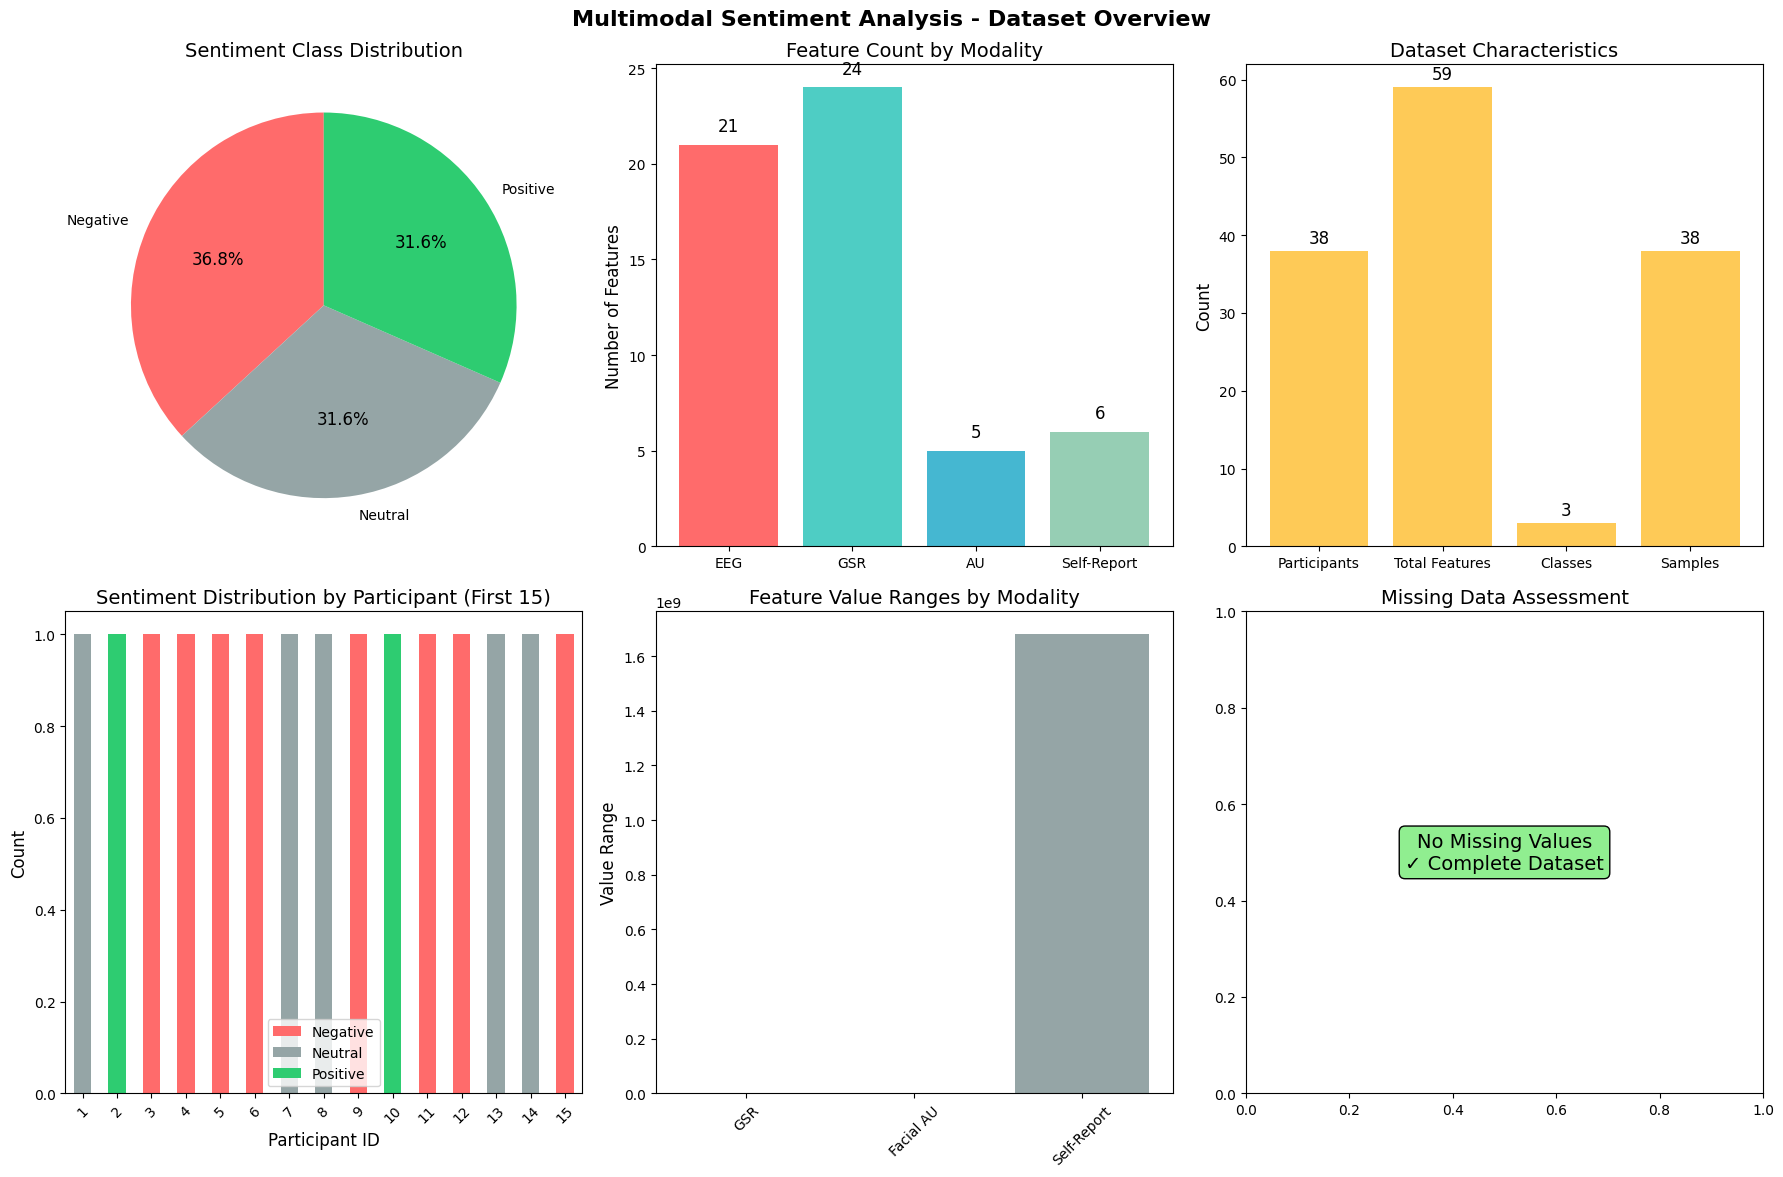

📊 Dataset Overview Dashboard created successfully!
📈 Key Statistics:
   • Total Participants: 38
   • Total Features: 59
   • Class Balance: {'Negative': 14, 'Neutral': 12, 'Positive': 12}
   • Feature Distribution: EEG(21), GSR(24), AU(5), SR(6)


In [25]:
# 1. Dataset Overview Dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Multimodal Sentiment Analysis - Dataset Overview', fontsize=16, fontweight='bold')

# 1.1 Class Distribution
sentiment_counts = sentiment_labels.value_counts().sort_index()
labels = ['Negative', 'Neutral', 'Positive']
colors = [sentiment_colors['Negative'], sentiment_colors['Neutral'], sentiment_colors['Positive']]

axes[0,0].pie(sentiment_counts.values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Sentiment Class Distribution')

# 1.2 Feature Count by Modality
modalities = ['EEG', 'GSR', 'AU', 'Self-Report']
feature_counts = [eeg_features_count, gsr_features_count, au_features_count, sr_features_count]
bars = axes[0,1].bar(modalities, feature_counts, color=[modality_colors['EEG'], modality_colors['GSR'], 
                                                        modality_colors['AU'], modality_colors['SR']])
axes[0,1].set_title('Feature Count by Modality')
axes[0,1].set_ylabel('Number of Features')
for bar, count in zip(bars, feature_counts):
    axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                   str(count), ha='center', va='bottom')

# 1.3 Dataset Size Overview
dataset_info = ['Participants', 'Total Features', 'Classes', 'Samples']
dataset_values = [len(multimodal_features), multimodal_features.shape[1]-1, len(sentiment_counts), len(multimodal_features)]
bars = axes[0,2].bar(dataset_info, dataset_values, color=modality_colors['Combined'])
axes[0,2].set_title('Dataset Characteristics')
axes[0,2].set_ylabel('Count')
for bar, value in zip(bars, dataset_values):
    axes[0,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                   str(value), ha='center', va='bottom')

# 1.4 Sentiment Distribution by Participant
participant_sentiment = pd.DataFrame({
    'participant_id': multimodal_features['participant_id'],
    'sentiment': sentiment_labels
})
sentiment_by_participant = participant_sentiment.groupby(['participant_id', 'sentiment']).size().unstack(fill_value=0)

# Show first 15 participants
if len(sentiment_by_participant) > 15:
    sentiment_subset = sentiment_by_participant.head(15)
else:
    sentiment_subset = sentiment_by_participant

sentiment_subset.plot(kind='bar', stacked=True, ax=axes[1,0], 
                     color=[sentiment_colors['Negative'], sentiment_colors['Neutral'], sentiment_colors['Positive']])
axes[1,0].set_title('Sentiment Distribution by Participant (First 15)')
axes[1,0].set_xlabel('Participant ID')
axes[1,0].set_ylabel('Count')
axes[1,0].legend(['Negative', 'Neutral', 'Positive'])
axes[1,0].tick_params(axis='x', rotation=45)

# 1.5 Feature Value Ranges by Modality
feature_ranges = []
modality_names = []

# EEG features
eeg_cols = [col for col in multimodal_features.columns if any(band in col for band in ['delta', 'theta', 'alpha', 'beta', 'gamma'])]
if eeg_cols:
    eeg_range = multimodal_features[eeg_cols].max().max() - multimodal_features[eeg_cols].min().min()
    feature_ranges.append(eeg_range)
    modality_names.append('EEG')

# GSR features  
gsr_cols = [col for col in multimodal_features.columns if 'GSR' in col]
if gsr_cols:
    gsr_range = multimodal_features[gsr_cols].max().max() - multimodal_features[gsr_cols].min().min()
    feature_ranges.append(gsr_range)
    modality_names.append('GSR') 

# AU features
au_cols = [col for col in multimodal_features.columns if any(emotion in col for emotion in ['happiness', 'sadness', 'anger', 'surprise', 'disgust', 'fear'])]
if au_cols:
    au_range = multimodal_features[au_cols].max().max() - multimodal_features[au_cols].min().min()
    feature_ranges.append(au_range)
    modality_names.append('Facial AU')

# SR features
sr_cols = [col for col in multimodal_features.columns if 'sr_' in col]
if sr_cols:
    sr_range = multimodal_features[sr_cols].max().max() - multimodal_features[sr_cols].min().min()
    feature_ranges.append(sr_range)
    modality_names.append('Self-Report')

bars = axes[1,1].bar(modality_names, feature_ranges, 
                     color=[modality_colors.get(name, '#95A5A6') for name in modality_names])
axes[1,1].set_title('Feature Value Ranges by Modality')
axes[1,1].set_ylabel('Value Range')
axes[1,1].tick_params(axis='x', rotation=45)

# 1.6 Missing Data Assessment
missing_data = multimodal_features.isnull().sum()
non_zero_missing = missing_data[missing_data > 0]

if len(non_zero_missing) > 0:
    axes[1,2].bar(range(len(non_zero_missing)), non_zero_missing.values)
    axes[1,2].set_title('Missing Values by Feature')
    axes[1,2].set_ylabel('Missing Count')
    axes[1,2].set_xticks(range(len(non_zero_missing)))
    axes[1,2].set_xticklabels(non_zero_missing.index, rotation=45, ha='right')
else:
    axes[1,2].text(0.5, 0.5, 'No Missing Values\n✓ Complete Dataset', 
                   ha='center', va='center', transform=axes[1,2].transAxes,
                   fontsize=14, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))
    axes[1,2].set_title('Missing Data Assessment')

plt.tight_layout()
plt.show()

print("📊 Dataset Overview Dashboard created successfully!")
print(f"📈 Key Statistics:")
print(f"   • Total Participants: {len(multimodal_features)}")
print(f"   • Total Features: {multimodal_features.shape[1]-1}")
print(f"   • Class Balance: {dict(zip(labels, sentiment_counts.values))}")
print(f"   • Feature Distribution: EEG({eeg_features_count}), GSR({gsr_features_count}), AU({au_features_count}), SR({sr_features_count})")

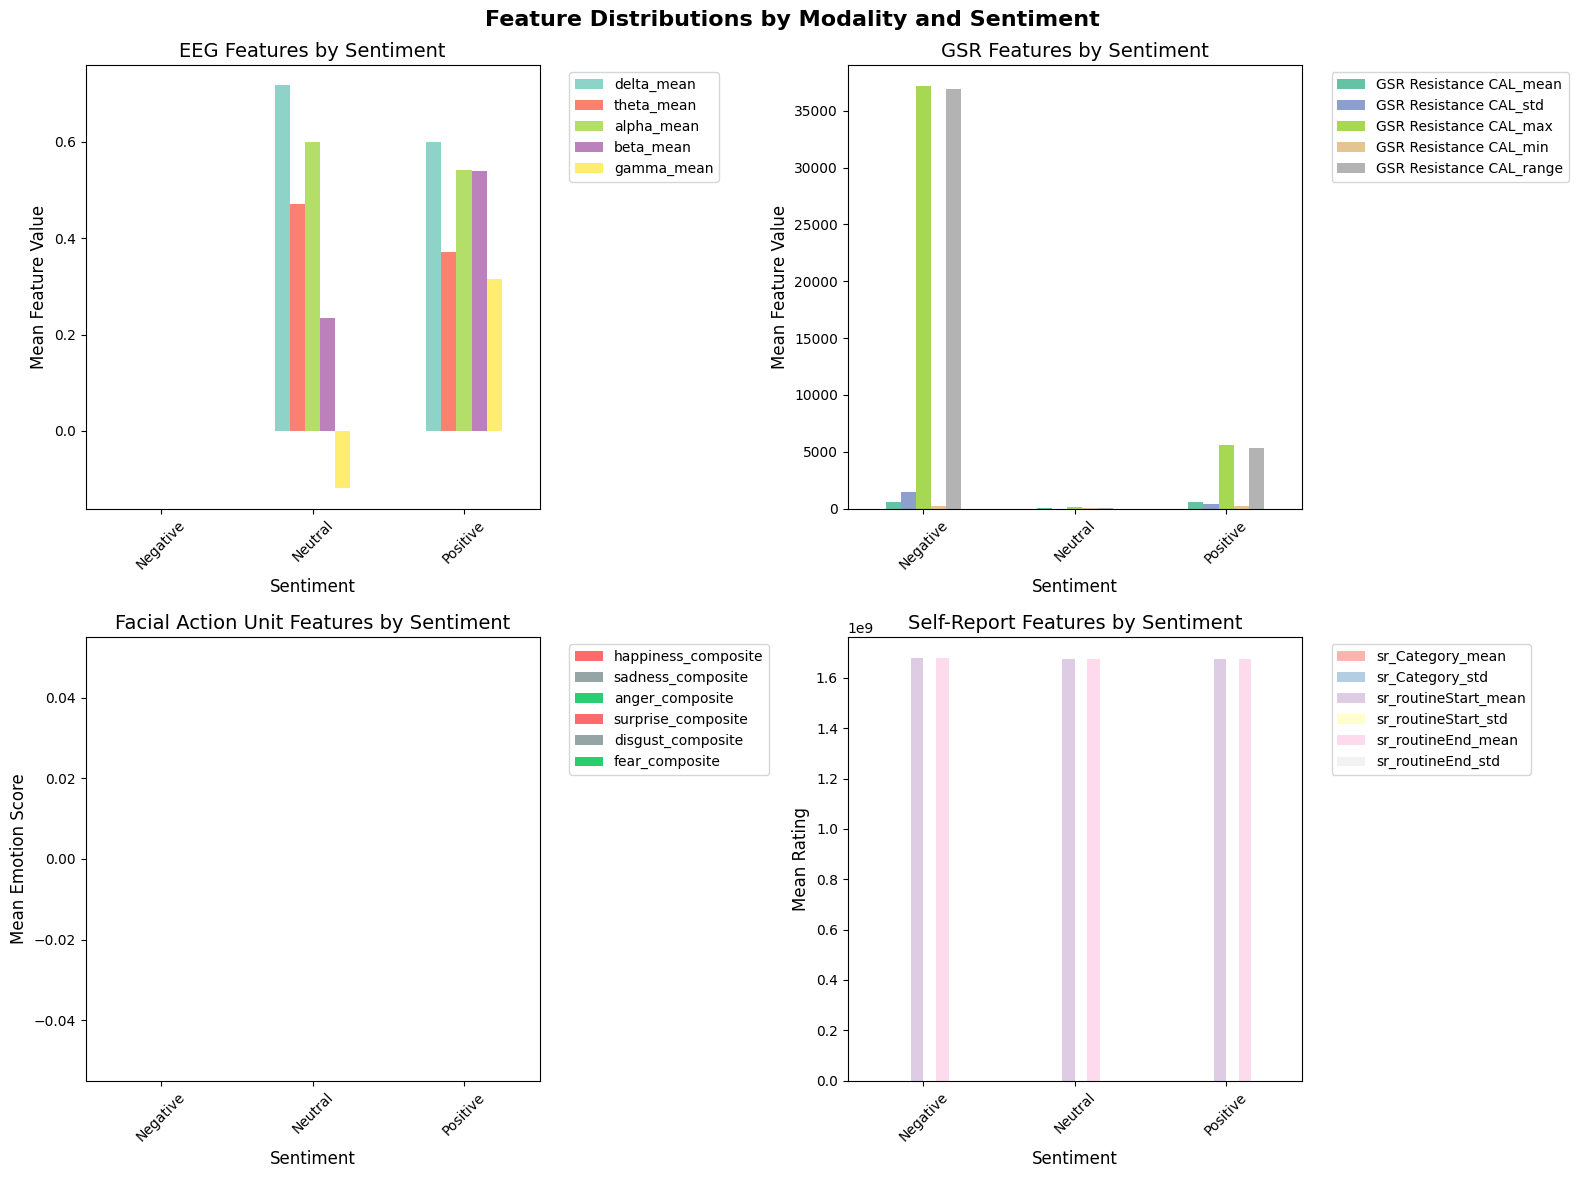

📊 Modality-specific feature distributions created!
🔍 These visualizations help identify which features are most discriminative for sentiment classification.


In [26]:
# 2. Modality-Specific Feature Distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  
fig.suptitle('Feature Distributions by Modality and Sentiment', fontsize=16, fontweight='bold')

# 2.1 EEG Feature Distribution by Sentiment
eeg_cols = [col for col in multimodal_features.columns if any(band in col for band in ['delta', 'theta', 'alpha', 'beta', 'gamma'])]
if eeg_cols:
    # Select key EEG features for visualization
    key_eeg_features = [col for col in eeg_cols if 'mean' in col][:5]  # Top 5 mean features
    
    eeg_sentiment_data = []
    for sentiment_val, sentiment_name in enumerate(['Negative', 'Neutral', 'Positive']):
        mask = sentiment_labels == sentiment_val
        if mask.sum() > 0:
            eeg_data = multimodal_features.loc[mask, key_eeg_features].mean()
            eeg_sentiment_data.append([sentiment_name] + eeg_data.values.tolist())
    
    if eeg_sentiment_data:
        eeg_df = pd.DataFrame(eeg_sentiment_data, columns=['Sentiment'] + key_eeg_features)
        eeg_df.set_index('Sentiment')[key_eeg_features].plot(kind='bar', ax=axes[0,0], 
                                                             color=plt.cm.Set3(np.linspace(0, 1, len(key_eeg_features))))
        axes[0,0].set_title('EEG Features by Sentiment')
        axes[0,0].set_ylabel('Mean Feature Value')
        axes[0,0].tick_params(axis='x', rotation=45)
        axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 2.2 GSR Feature Distribution by Sentiment  
gsr_cols = [col for col in multimodal_features.columns if 'GSR' in col]
if gsr_cols:
    key_gsr_features = gsr_cols[:5]  # First 5 GSR features
    
    gsr_sentiment_data = []
    for sentiment_val, sentiment_name in enumerate(['Negative', 'Neutral', 'Positive']):
        mask = sentiment_labels == sentiment_val
        if mask.sum() > 0:
            gsr_data = multimodal_features.loc[mask, key_gsr_features].mean()
            gsr_sentiment_data.append([sentiment_name] + gsr_data.values.tolist())
    
    if gsr_sentiment_data:
        gsr_df = pd.DataFrame(gsr_sentiment_data, columns=['Sentiment'] + key_gsr_features)
        gsr_df.set_index('Sentiment')[key_gsr_features].plot(kind='bar', ax=axes[0,1],
                                                             color=plt.cm.Set2(np.linspace(0, 1, len(key_gsr_features))))
        axes[0,1].set_title('GSR Features by Sentiment')
        axes[0,1].set_ylabel('Mean Feature Value')
        axes[0,1].tick_params(axis='x', rotation=45)
        axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 2.3 Facial AU Feature Distribution by Sentiment
au_cols = [col for col in multimodal_features.columns if any(emotion in col for emotion in ['happiness', 'sadness', 'anger', 'surprise', 'disgust', 'fear'])]
if au_cols:
    au_sentiment_data = []
    for sentiment_val, sentiment_name in enumerate(['Negative', 'Neutral', 'Positive']):
        mask = sentiment_labels == sentiment_val
        if mask.sum() > 0:
            au_data = multimodal_features.loc[mask, au_cols].mean()
            au_sentiment_data.append([sentiment_name] + au_data.values.tolist())
    
    if au_sentiment_data:
        au_df = pd.DataFrame(au_sentiment_data, columns=['Sentiment'] + au_cols)
        au_df.set_index('Sentiment')[au_cols].plot(kind='bar', ax=axes[1,0],
                                                   color=[sentiment_colors[sent] for sent in ['Negative', 'Neutral', 'Positive']])
        axes[1,0].set_title('Facial Action Unit Features by Sentiment')
        axes[1,0].set_ylabel('Mean Emotion Score')
        axes[1,0].tick_params(axis='x', rotation=45)
        axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 2.4 Self-Report Feature Distribution by Sentiment
sr_cols = [col for col in multimodal_features.columns if 'sr_' in col]
if sr_cols:
    sr_sentiment_data = []
    for sentiment_val, sentiment_name in enumerate(['Negative', 'Neutral', 'Positive']):
        mask = sentiment_labels == sentiment_val
        if mask.sum() > 0:
            sr_data = multimodal_features.loc[mask, sr_cols].mean()
            sr_sentiment_data.append([sentiment_name] + sr_data.values.tolist())
    
    if sr_sentiment_data:
        sr_df = pd.DataFrame(sr_sentiment_data, columns=['Sentiment'] + sr_cols)
        sr_df.set_index('Sentiment')[sr_cols].plot(kind='bar', ax=axes[1,1],
                                                   color=plt.cm.Pastel1(np.linspace(0, 1, len(sr_cols))))
        axes[1,1].set_title('Self-Report Features by Sentiment') 
        axes[1,1].set_ylabel('Mean Rating')
        axes[1,1].tick_params(axis='x', rotation=45)
        axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

print("📊 Modality-specific feature distributions created!")
print("🔍 These visualizations help identify which features are most discriminative for sentiment classification.")